## <font color='Blue'> Tehran House Prices.</font>

![](https://static.prod.iranwire.com/filer_public/3e/06/3e065f28-2351-43e3-8e32-fc37d17b92dc/tehran-house-prices-fact-check-iran-1.jpg)

#### This dataset contains information on residential property prices in Tehran, scraped from the Divar site. It includes features such as Price (USD), Price (IRR), Area, Room, Parking, Warehouse, Elevator availability, Address, and more. The data is intended for analyzing housing market trends and price predictions in Tehran's real estate sector.

#### Here we will use the "TehranHouse.csv" database that has been made available for use, below you will see an analysis of the data, the processing of this data and the use of the learning classification of machine models to achieve our goal.

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tehran-house-prices-dataset/TehranHouse.csv


#### Importing Libraries.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

## <font color='blue'> 1. Importing Dataset. </font>

In [40]:
df = pd.read_csv('TehranHouse.csv', sep = ',')

#### Here we can see that we have categorical and continuous variables:

- Price (USD): The price of the property in US Dollars.
- Price (IRR): The price of the property in Iranian Rials.
- Area: The total area of the property in square meters.
- Room: The number of rooms in the property.
- Parking: Availability of parking (Yes/No).
- Warehouse: Availability of a warehouse (Yes/No).
- Elevator: Availability of an elevator (Yes/No).
- Address: The location of the property.

In [ ]:
df.head(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000.000,61666.670
1,60,1,True,True,True,Shahran,1850000000.000,61666.670
2,79,2,True,True,True,Pardis,550000000.000,18333.330
3,95,2,True,True,True,Shahrake Qods,902500000.000,30083.330
4,123,2,True,True,True,Shahrake Gharb,7000000000.000,233333.330


#### Here we will delete the Price column and leave the price only in dollars, which is the metric we will use in our analysis.

In [1]:
df = df.drop("Price", axis = 1)

NameError: name 'df' is not defined

In [43]:
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

#### We can confirm that our database has 7 columns and only 3479 values, which limits our project as we do not have much information, both descriptive and in terms of the quantity of values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3473 non-null   float64
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(1)
memory usage: 119.0+ KB


#### We can check that we have some null values ​​in the Address column which is the location of the house and some values ​​in "Area", there are few, around 20 so I will choose to remove these values.

In [45]:
df.isnull().sum()

Area           6
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price(USD)     0
dtype: int64

In [46]:
df = df.dropna()

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df.describe()

,Area,Room,Price(USD)
count,3450.000,3450.000,3450.000
mean,106.917,2.081,179185.420
std,69.551,0.760,270863.932
min,30.000,0.000,120.000
25%,69.000,2.000,47308.333
50%,90.000,2.000,96666.670
75%,120.000,2.000,200000.000
max,929.000,5.000,3080000.000


#### As we can see, our Address variable has 192 values, which makes the analysis and use of Machine Learning models a little complicated, which is what I'm going to do here and classify this "Address" column into 4 groups according to the average value of the house in that region.

#### Here we will divide into 4 groups:

- 1 group: from the lowest average to the average of 35% of the data, we can classify as the cheapest houses.

- 2 group: between 35% and 70% of the data, we can classify as average houses.

- 3 group: from 70% to 95%, we can classify as expensive houses.

- 4 group: from 95% to 100% of the data, and here we can classify the 5% of the highest prices as the really expensive houses.

In [48]:
df["Address"].value_counts()

Address
Punak                     161
Pardis                    146
West Ferdows Boulevard    145
Gheitarieh                140
Shahran                   130
                         ... 
Chardangeh                  1
Mehrabad                    1
Pakdasht KhatunAbad         1
Kazemabad                   1
Yakhchiabad                 1
Name: count, Length: 192, dtype: int64

In [49]:
df['Average_Price'] = df.groupby('Address')['Price(USD)'].transform('mean')

In [50]:
percentis = [0, 0.35, 0.70, 0.95, 1.0]
limits = df['Price(USD)'].quantile(percentis).values
df['address_groups'] = pd.cut(df['Price(USD)'], bins=limits, labels=['0', '1', '2', '3'], include_lowest=True)


## <font color='blue'> 2. Data Analysis </font>

#### Categorical Variables

#### By analyzing our categorical variables we can verify some patterns in our database, most of the houses in our database have 2 bedrooms and the vast majority of them have a Warehouse, Elevator and Parking, which is very curious information, as that in the 3 columns we have values ​​above 80% of the data, when we look at the variable that we created we can verify the distribution that we talked about above.

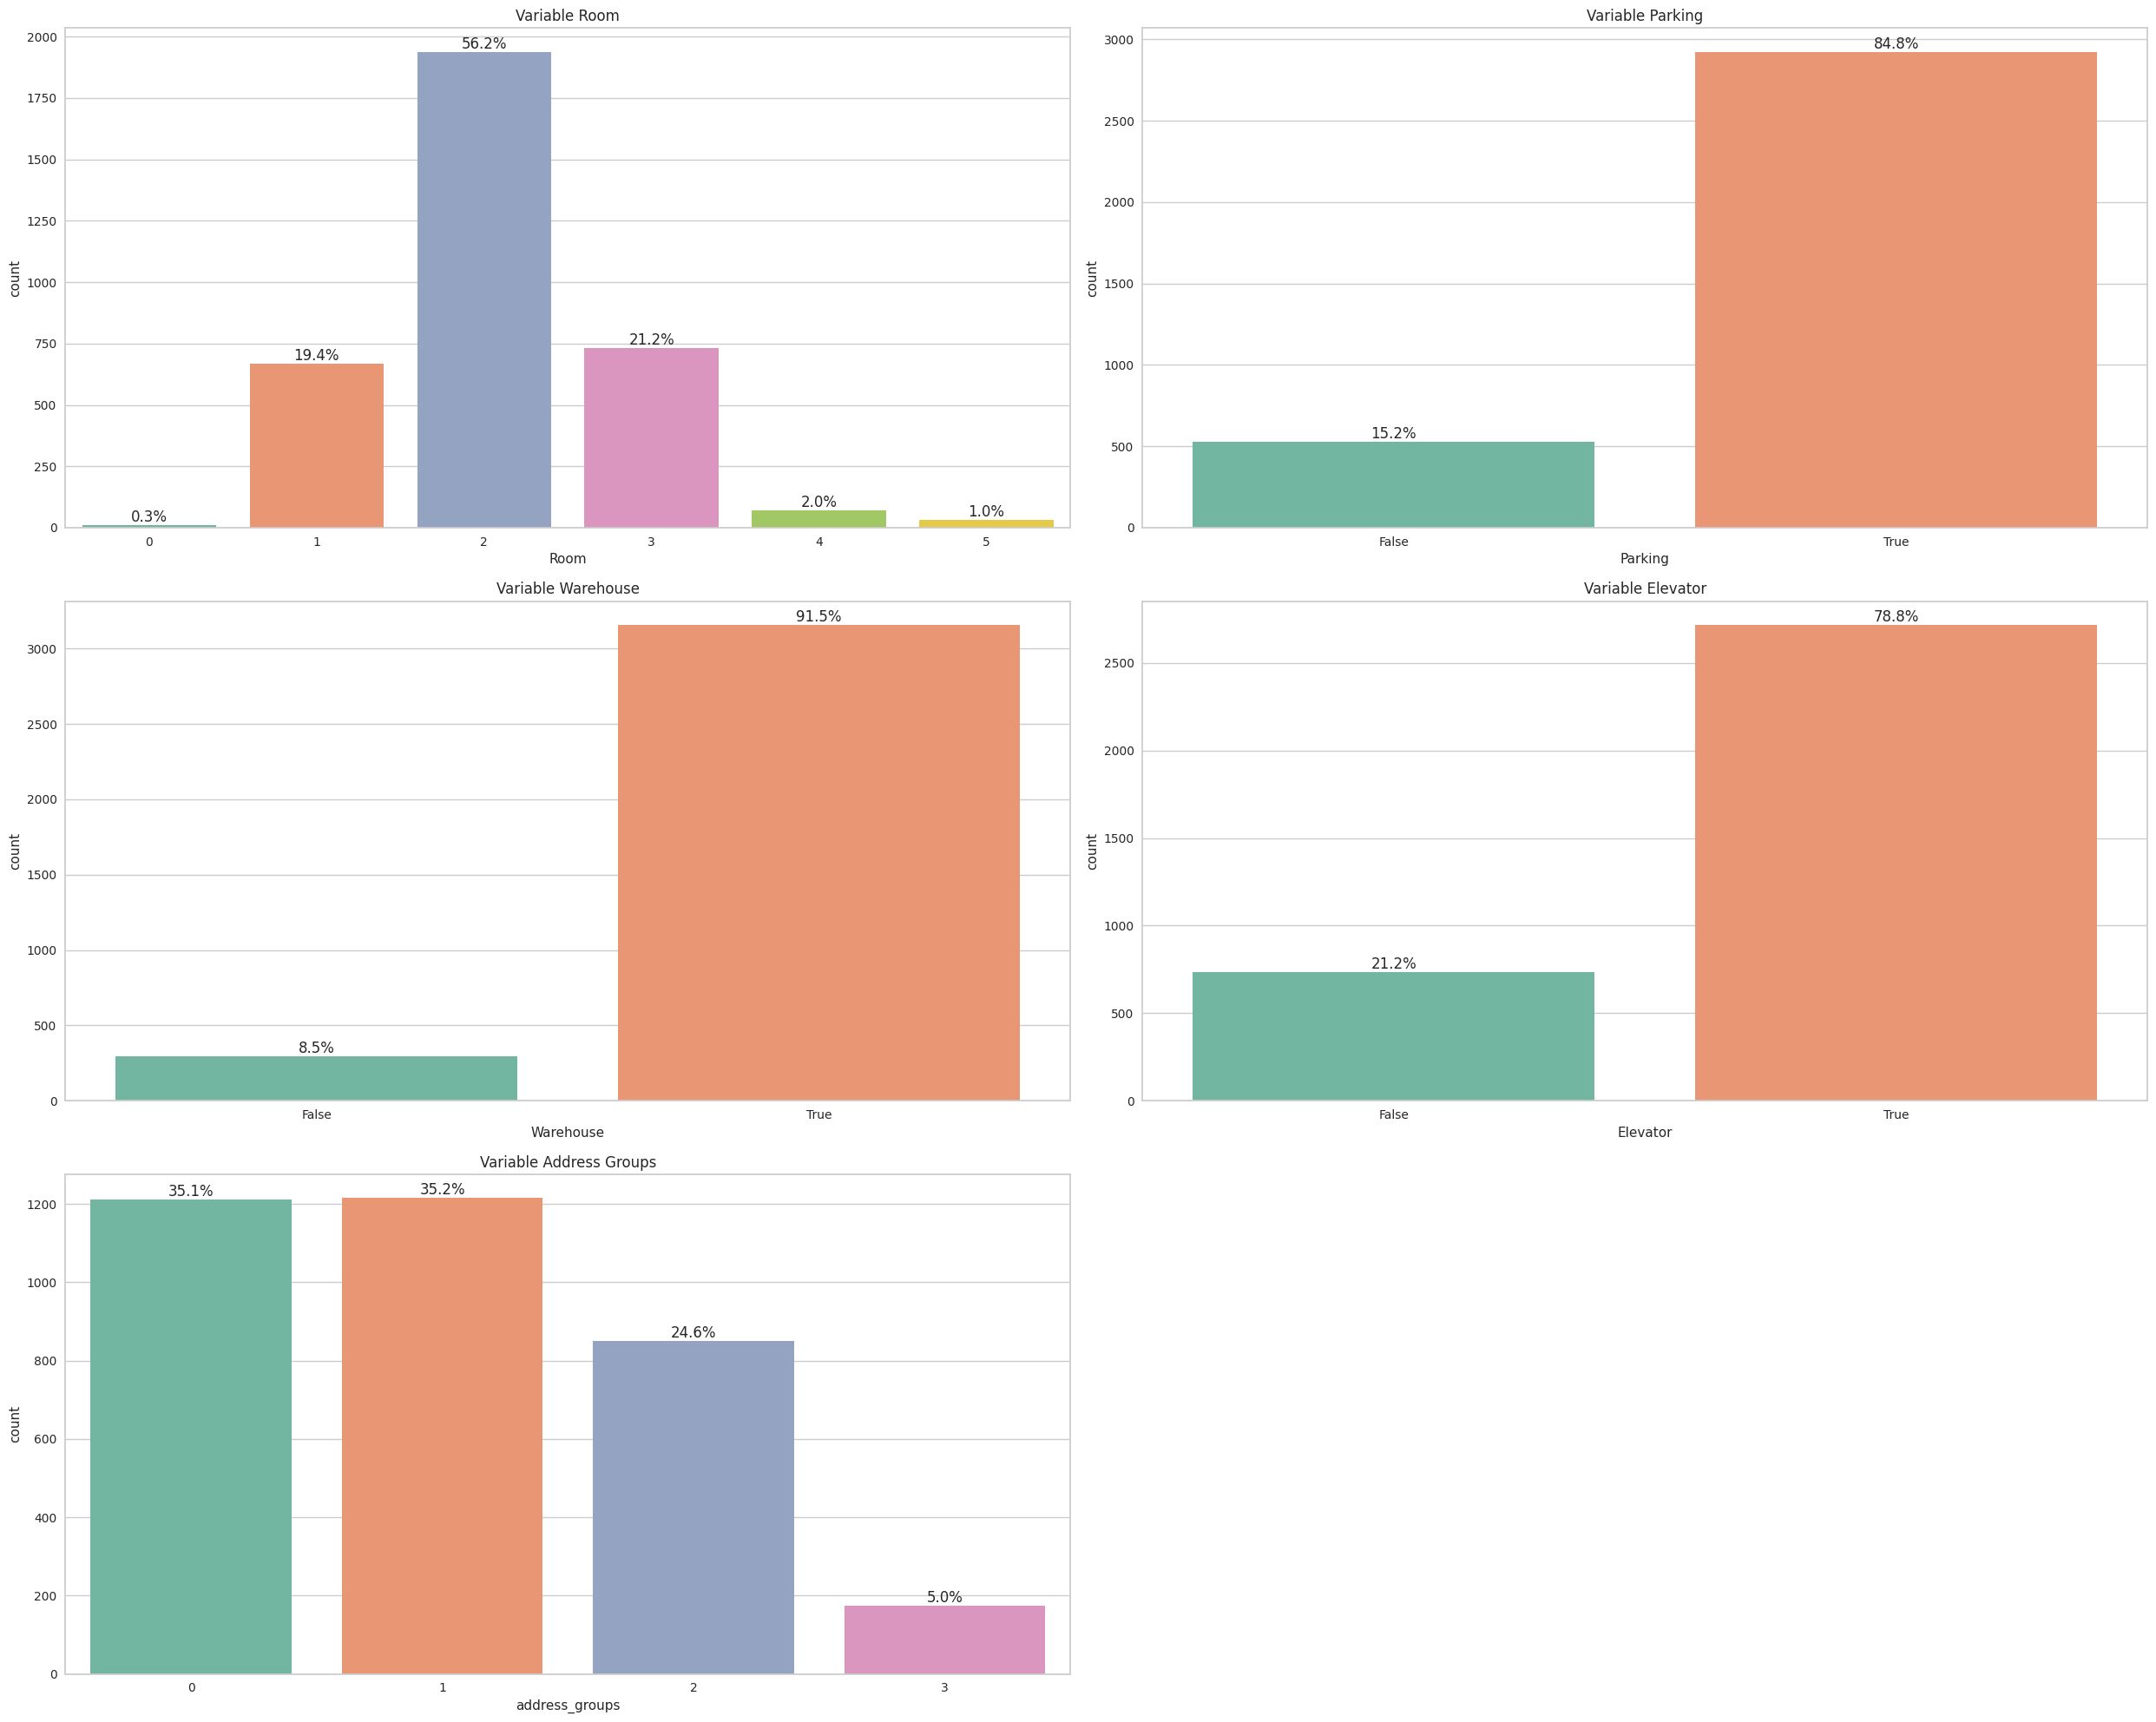

In [51]:

def add_percentage(ax, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.figure(figsize = (25,20))

plt.subplot(3,2,1)
plt.gca().set_title('Variable Room')
ax1 = sns.countplot(x = 'Room', palette='Set2', data=df)
add_percentage(ax1, len(df['Room']))

plt.subplot(3,2,2)
plt.gca().set_title('Variable Parking')
ax2 = sns.countplot(x = 'Parking', palette='Set2', data=df)
add_percentage(ax2, len(df['Parking']))

plt.subplot(3,2,3)
plt.gca().set_title('Variable Warehouse')
ax3 = sns.countplot(x = 'Warehouse', palette='Set2', data=df)
add_percentage(ax3, len(df['Warehouse']))

plt.subplot(3,2,4)
plt.gca().set_title('Variable Elevator')
ax4 = sns.countplot(x = 'Elevator', palette='Set2', data=df)
add_percentage(ax4, len(df['Elevator']))

plt.subplot(3,2,5)
plt.gca().set_title('Variable Address Groups')
ax4 = sns.countplot(x = 'address_groups', palette='Set2', data=df)
add_percentage(ax4, len(df['address_groups']))


plt.tight_layout()
plt.show()

#### Continuous Variables

#### Looking here at our continuous variables we can see that most of our data has an area between 0-200 and when we talk about price, the vast majority of data is between 0 and 200 thousand, having the same behavior between the two variables, which is that the higher the value, the smaller the amount of data available.

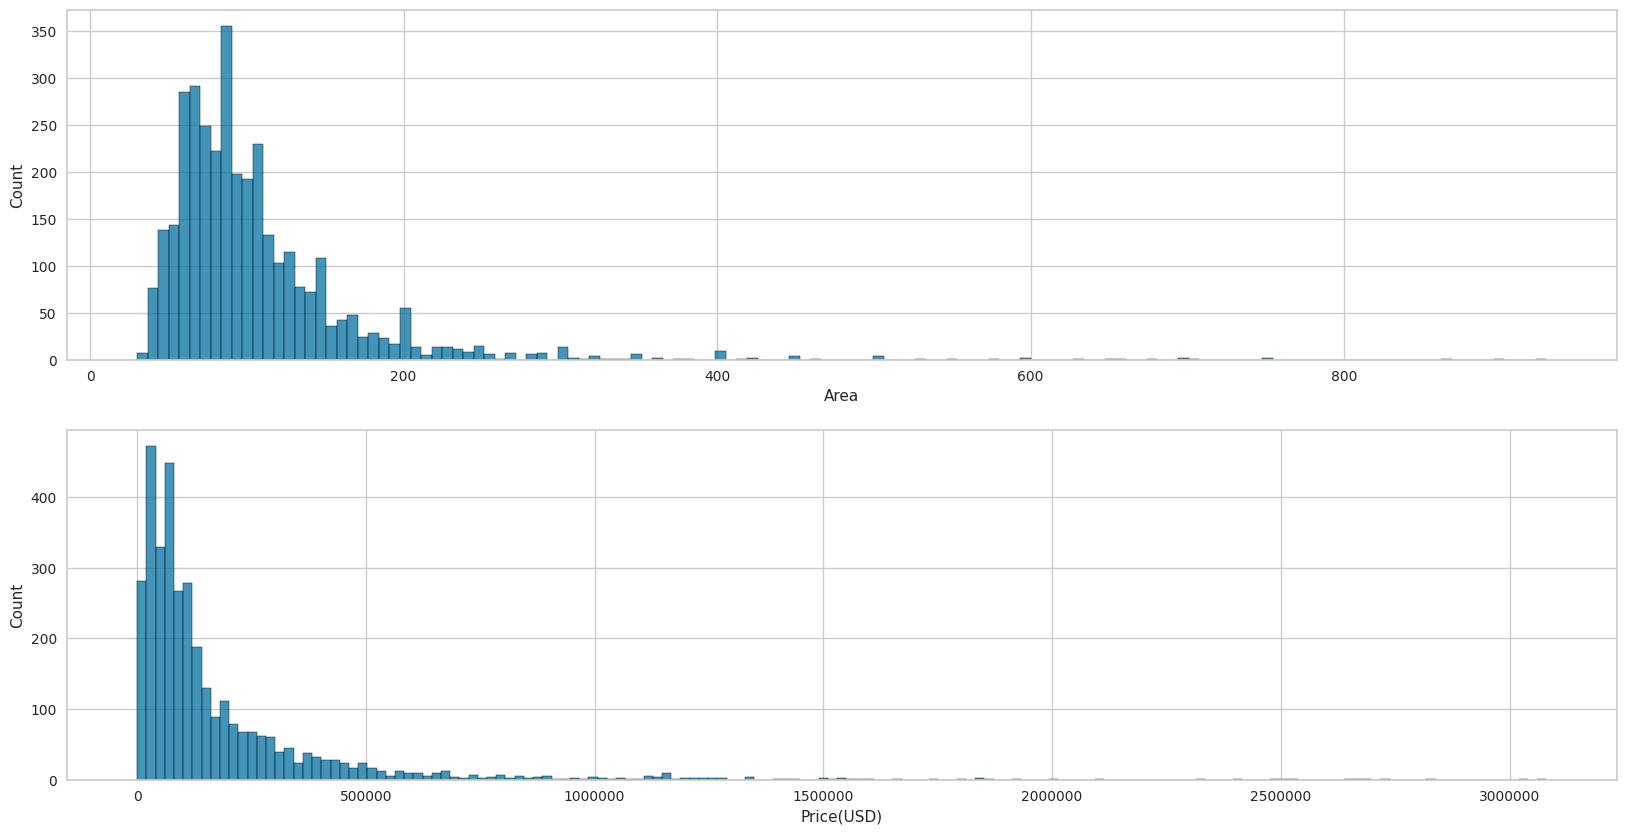

In [52]:
plt.figure(figsize = (20, 10))

plt.subplot(2, 1, 1)
sns.histplot(x = df['Area'], kde = False)

plt.subplot(2, 1, 2)
sns.histplot(x = df['Price(USD)'], kde = False)

plt.ticklabel_format(style='plain', axis='both') 
plt.show()

#### When we look at the boxplot of our 2 continuous variables we can see that we have some outliers, but I will choose to leave them as these values ​​make perfect sense when we look at real life.

<Axes: title={'center': 'Boxplot Area'}, xlabel='Area'>

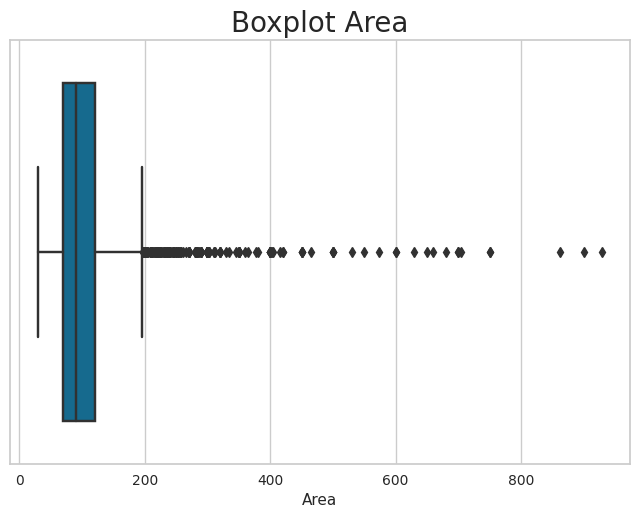

In [53]:
plt.title("Boxplot Area", fontdict = {'fontsize': 20})
sns.boxplot(x=df["Area"])

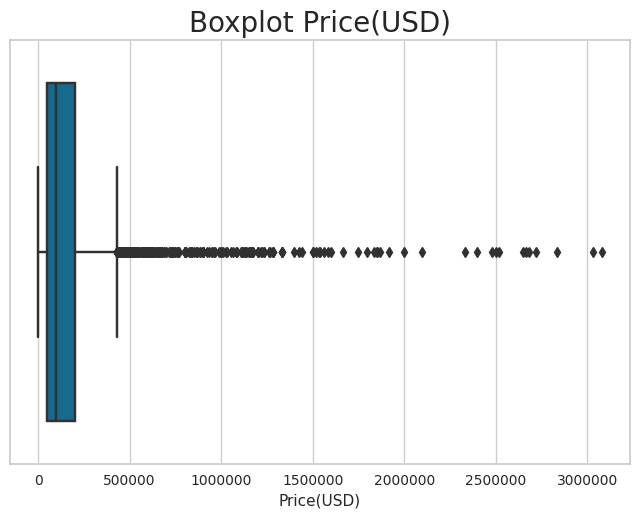

In [54]:
plt.title("Boxplot Price(USD)", fontdict = {'fontsize': 20})
sns.boxplot(x=df["Price(USD)"])
plt.ticklabel_format(style='plain', axis='x') 

#### Bivariate Analysis

#### Starting our bivariate analysis between our variables and analyzing our target variable we can confirm what we could previously predict, the greater the number of rooms, and the possibility of having a Warehouse, Elevator or Parking, the more likely the case will have a high value, which makes a lot of sense, when we look at the variable we created, we can also confirm that our data distribution was done well, distributing the groups by the average value of the region.

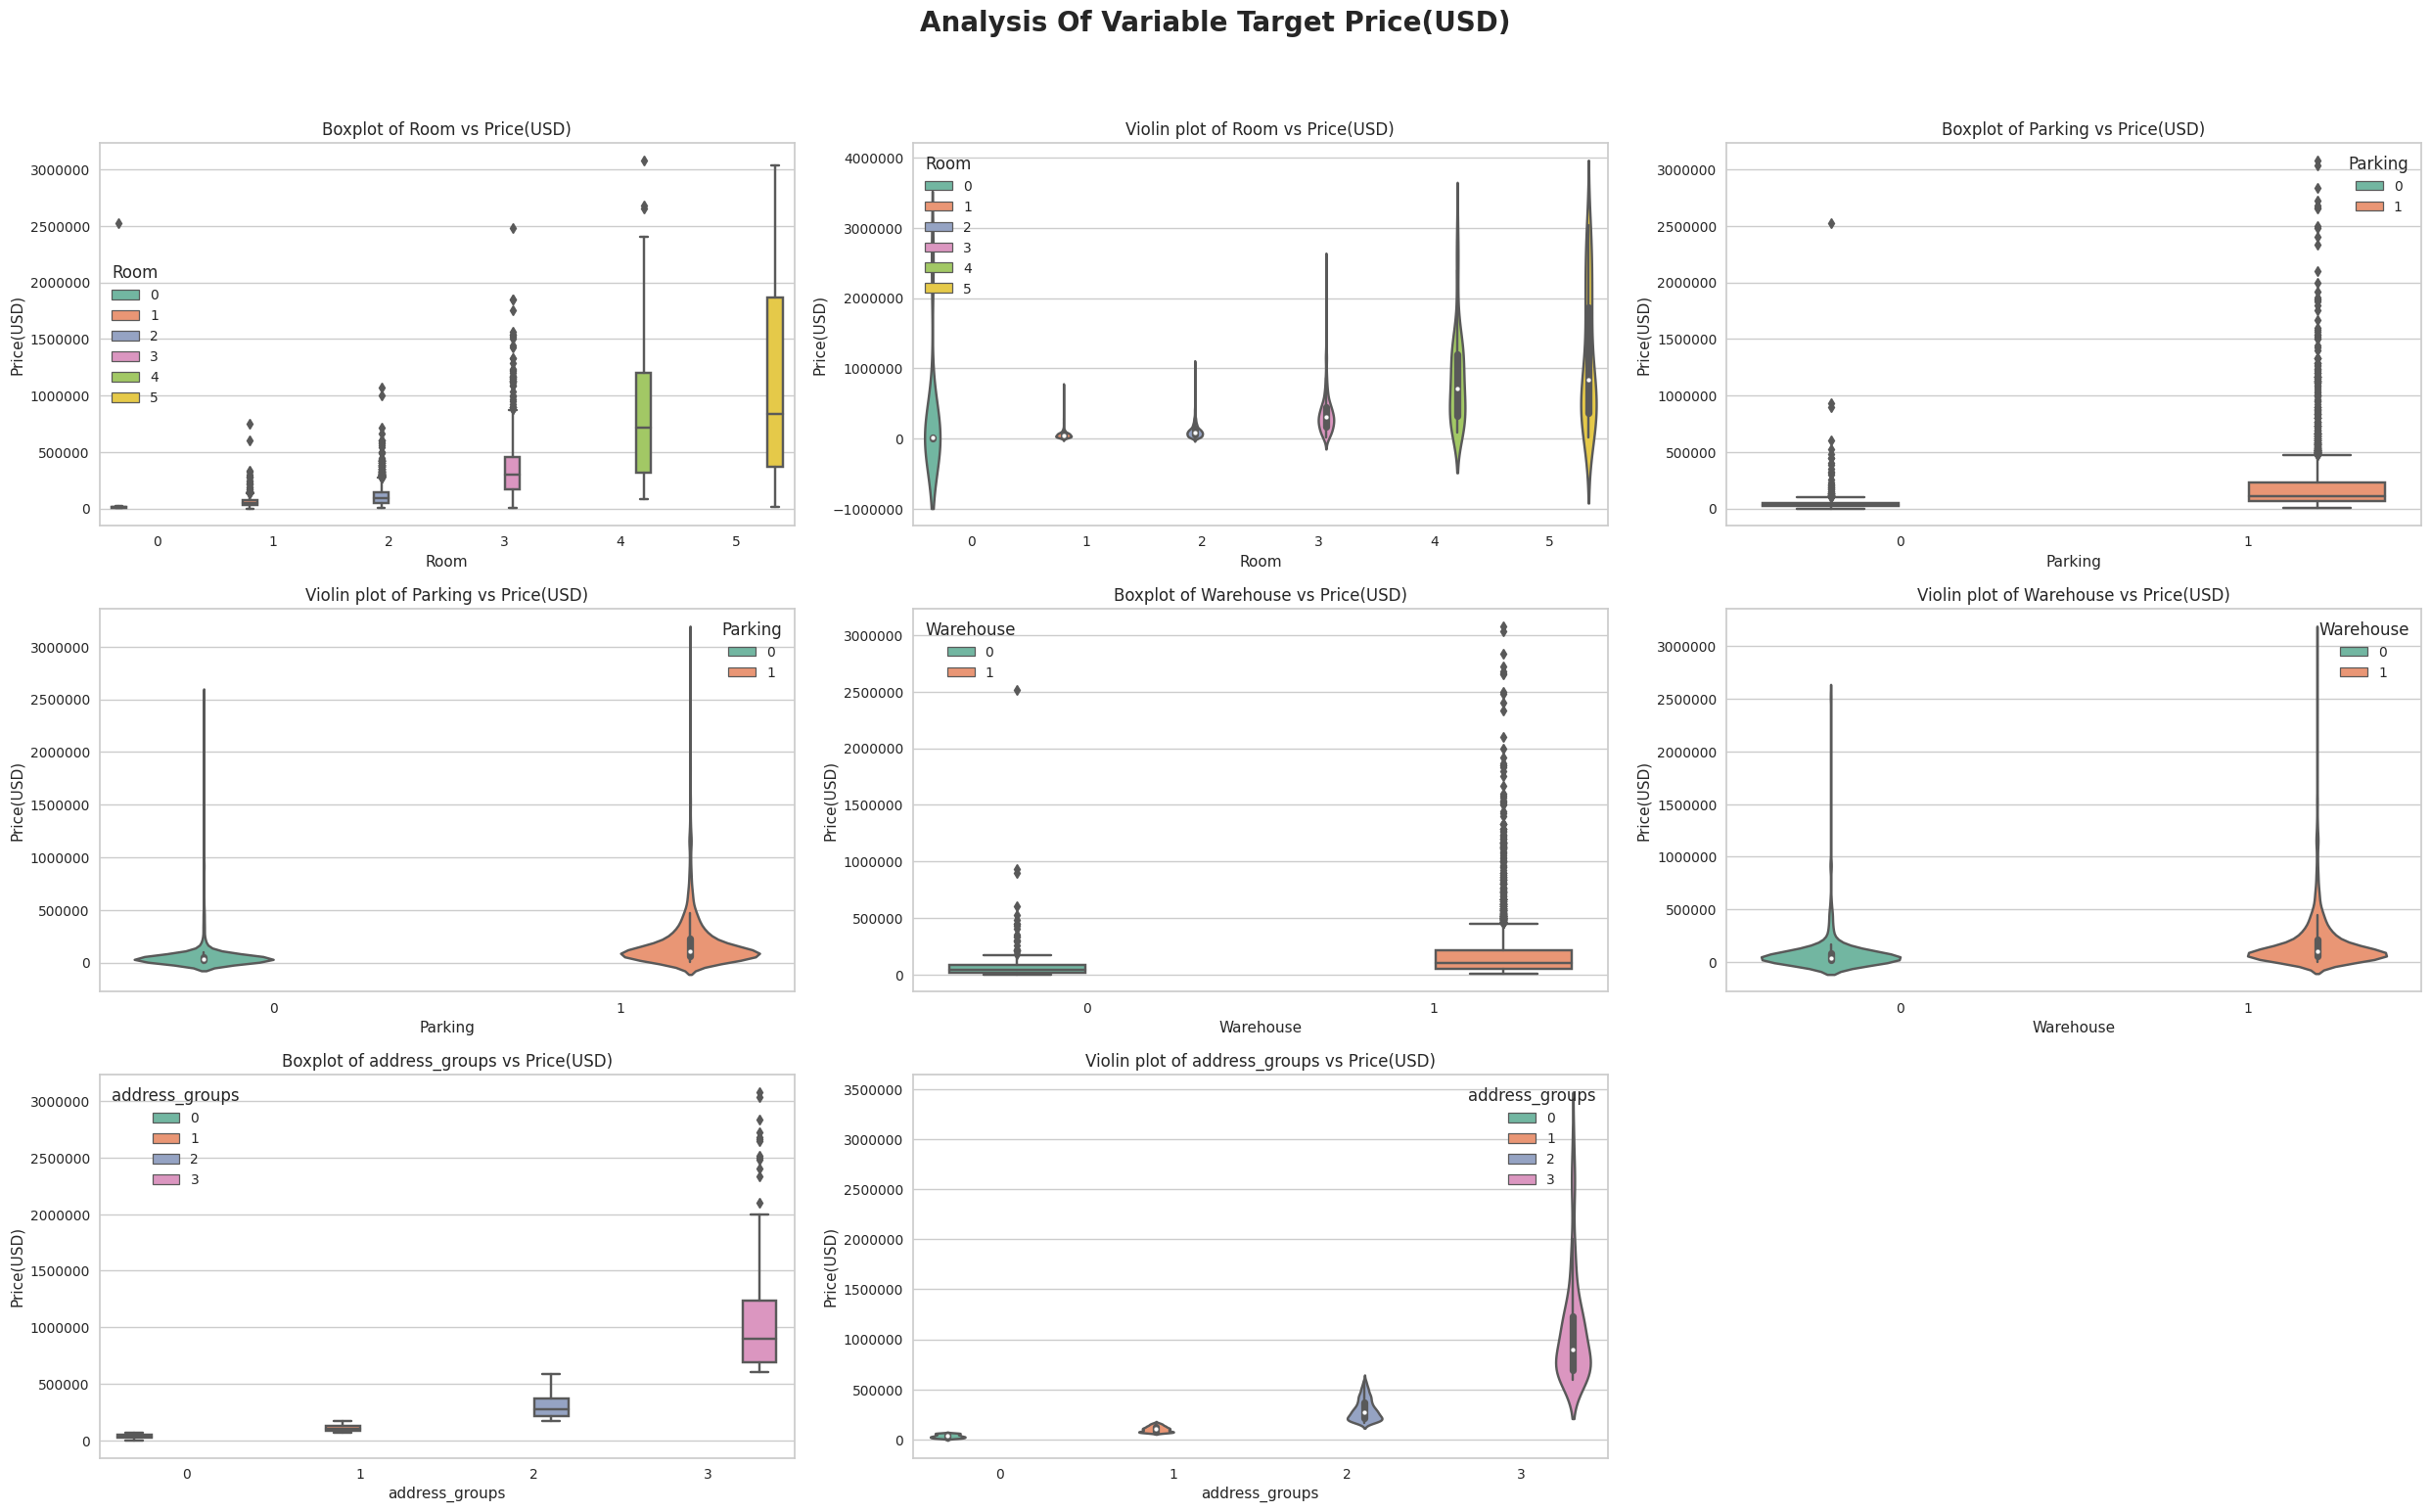

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 25))
plt.suptitle("Analysis Of Variable Target Price(USD)", fontweight="bold", fontsize=20)

# Criação dos subplots
axes = []

axes.append(plt.subplot(5, 3, 1))
sns.boxplot(x='Room', y='Price(USD)', hue="Room", data=df, palette='Set2')
plt.title('Boxplot of Room vs Price(USD)')

axes.append(plt.subplot(5, 3, 2))
sns.violinplot(x='Room', y='Price(USD)', hue="Room", data=df, palette='Set2')
plt.title('Violin plot of Room vs Price(USD)')

axes.append(plt.subplot(5, 3, 3))
sns.boxplot(x='Parking', y='Price(USD)', hue="Parking", data=df, palette='Set2')
plt.title('Boxplot of Parking vs Price(USD)')

axes.append(plt.subplot(5, 3, 4))
sns.violinplot(x='Parking', y='Price(USD)', hue="Parking", data=df, palette='Set2')
plt.title('Violin plot of Parking vs Price(USD)')

axes.append(plt.subplot(5, 3, 5))
sns.boxplot(x='Warehouse', y='Price(USD)', hue="Warehouse", data=df, palette='Set2')
plt.title('Boxplot of Warehouse vs Price(USD)')

axes.append(plt.subplot(5, 3, 6))
sns.violinplot(x='Warehouse', y='Price(USD)', hue="Warehouse", data=df, palette='Set2')
plt.title('Violin plot of Warehouse vs Price(USD)')

axes.append(plt.subplot(5, 3, 7))
sns.boxplot(x='address_groups', y='Price(USD)', hue="address_groups", data=df, palette='Set2')
plt.title('Boxplot of address_groups vs Price(USD)')

axes.append(plt.subplot(5, 3, 8))
sns.violinplot(x='address_groups', y='Price(USD)', hue="address_groups", data=df, palette='Set2')
plt.title('Violin plot of address_groups vs Price(USD)')


# Aplicar ticklabel_format a todos os subplots
for ax in axes:
    ax.ticklabel_format(style='plain', axis='y')

# Ajuste do layout e exibição
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### When we compare the variables area x number of rooms we can also confirm the obvious, that the greater the number of rooms, the more likely it is to have a larger area.

Text(0.5, 1.0, 'Boxplot of Room vs Area')

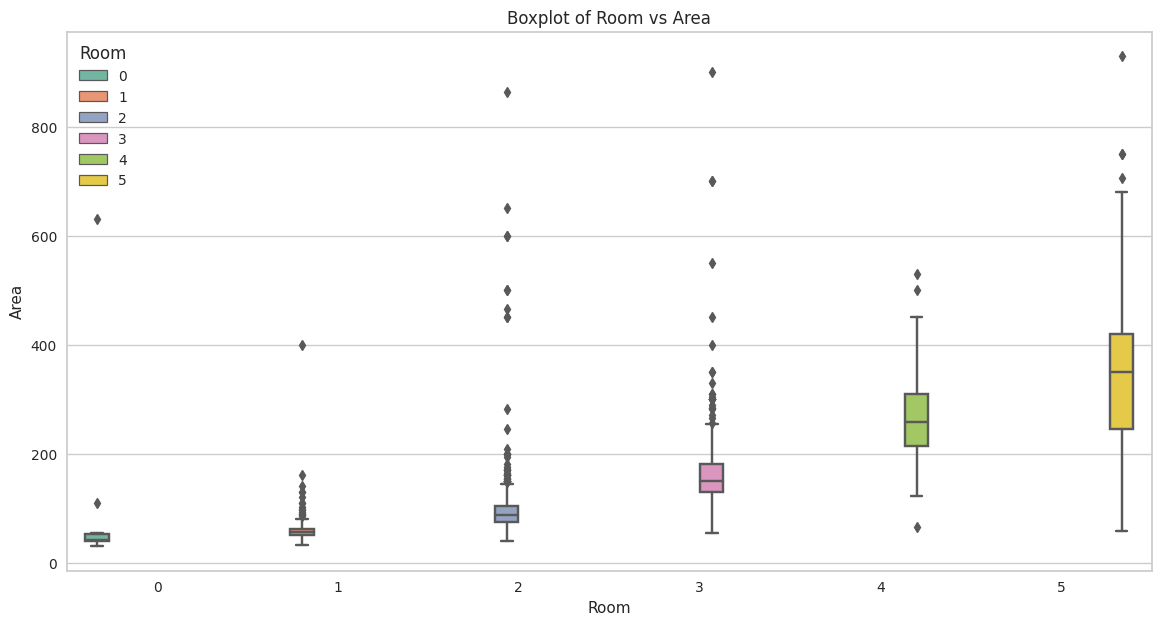

In [56]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='Room', y='Area', hue="Room", data=df, palette='Set2')
plt.title('Boxplot of Room vs Area')

#### Here, comparing the price of the house with the area we can confirm the behavior that generally the larger the area, the higher the price of the house, not all cases confirm this situation but most of them, we can also verify that the majority of houses higher values ​​have Parking, Warehouse and Elevator (a little less compared to the other two),

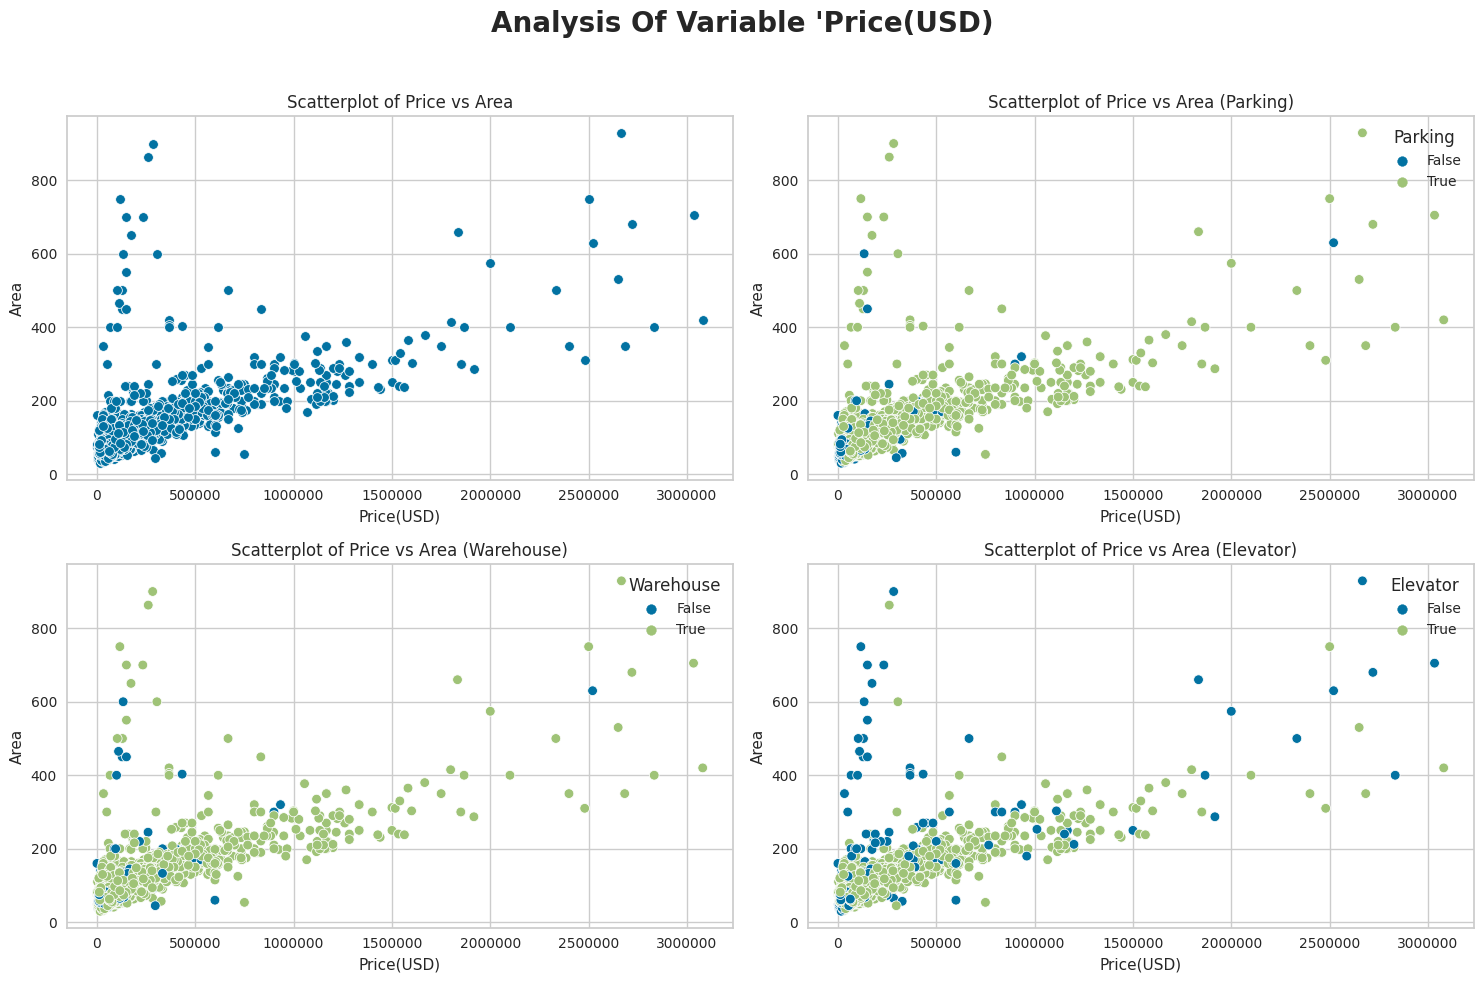

In [57]:
plt.figure(figsize=(15, 10))
plt.suptitle("Analysis Of Variable 'Price(USD)", fontweight="bold", fontsize=20)

# Lista para armazenar os eixos
axes = []

# Primeiro gráfico: Scatterplot
axes.append(plt.subplot(2, 2, 1))
sns.scatterplot(x='Price(USD)', y='Area', data=df)
plt.title('Scatterplot of Price vs Area')

axes.append(plt.subplot(2, 2, 2))
sns.scatterplot(x='Price(USD)', y='Area', hue="Parking", data=df)
plt.title('Scatterplot of Price vs Area (Parking)')

axes.append(plt.subplot(2, 2, 3))
sns.scatterplot(x='Price(USD)', y='Area', hue="Warehouse", data=df)
plt.title('Scatterplot of Price vs Area (Warehouse)')

axes.append(plt.subplot(2, 2, 4))
sns.scatterplot(x='Price(USD)', y='Area', hue="Elevator", data=df)
plt.title('Scatterplot of Price vs Area (Elevator)')

# Aplicar a formatação de ticks em todos os eixos
for ax in axes:
    ax.ticklabel_format(style='plain', axis='both')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajusta o layout
plt.show()


#### When we compare the price variable with the number of bedrooms, we can see that generally the most expensive houses have at least between 3-5 bedrooms, with some exceptions.

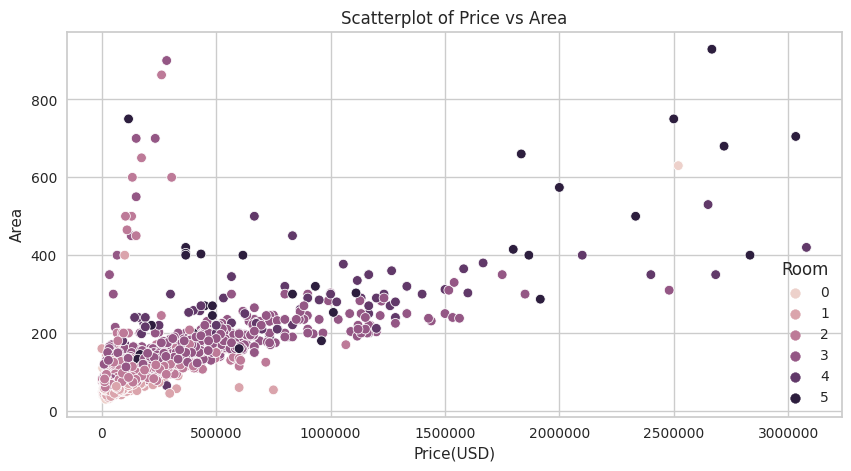

In [58]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Price(USD)', y='Area', hue="Room", data=df)
plt.title('Scatterplot of Price vs Area')
plt.ticklabel_format(style='plain', axis='both')

## <font color='blue'> 3. Model Building. </font>

#### Label Encoder
- Here we are going to use the LabelEncoder to transform our categorical variables into numeric variables.

In [59]:
label_encoder_Parking= LabelEncoder()
label_encoder_Warehouse = LabelEncoder()
label_encoder_Elevator = LabelEncoder()
label_encoder_Address = LabelEncoder()

df['Parking'] = label_encoder_Parking.fit_transform(df['Parking'])
df['Warehouse'] = label_encoder_Warehouse.fit_transform(df['Warehouse'])
df['Elevator'] = label_encoder_Elevator.fit_transform(df['Elevator'])
df['Address'] = label_encoder_Address.fit_transform(df['Address'])

In [60]:
df = df.drop(["Average_Price", "Address"], axis = 1)

#### Separating into features variables and target variable.

In [61]:
X = df.drop('Price(USD)', axis = 1)
X = X.values
y = df['Price(USD)']

#### StandardScaler
- Here we will use StandardScaler to put our data in the same scale.

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)
y_standard = scaler.fit_transform(y.values.reshape(-1,1))

#### Transforming Data into Train e Test, here we will use 30% of our data to test the machine learning models.

In [63]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_standard, y, test_size = 0.3, random_state = 0)

#### Linear Regression

- Here we will use the Linear Regression Model.

#### Running linear regression on our first machine learning model we achieved an accuracy of 66%, here I believe that the most important value is the Mean Absolute Error as we seek a better attempt to get the average right and not put so much weight on the outliers.

In [64]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_normal_score_train = lr_model.score(X_train, y_train)
lr_normal_score_test = lr_model.score(X_test, y_test)
previsoes = lr_model.predict(X_test)
mae_lr_normal = mean_absolute_error(y_test, previsoes)
rmse_lr_normal = np.sqrt(mean_squared_error(y_test, previsoes))

print('Train :', lr_normal_score_train)
print('Test :', lr_normal_score_test)
print('Mean Absolute Error :', mae_lr_normal)
print('Root Mean Square Error :', rmse_lr_normal)

Train : 0.6449130456844011
Test : 0.6612700926123931
Mean Absolute Error : 82846.98794286554
Root Mean Square Error : 177308.7620200418


#### Decision Tree

- Here we will use the Decision Tree Model, we will test Entropy and Gini calculations.
- Here we are applying GridSearch to check which are the best metrics to use.

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

min_split = np.array([2, 3, 4, 5, 6, 7])
max_nvl = np.array([3, 4, 5, 6, 7, 9, 11])
alg = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
values_grid = {'min_samples_split': min_split, 'max_depth': max_nvl, 'criterion': alg}

model = DecisionTreeRegressor()
gridDecisionTree = GridSearchCV(estimator = model, param_grid = values_grid, cv = 5, n_jobs = -1)
gridDecisionTree.fit(X_train, y_train)

print('Mín Split: ', gridDecisionTree.best_estimator_.min_samples_split)
print('Max Nvl: ', gridDecisionTree.best_estimator_.max_depth)
print('Algorithm: ', gridDecisionTree.best_estimator_.criterion)
print('Score: ', gridDecisionTree.best_score_)

Mín Split:  4
Max Nvl:  4
Algorithm:  squared_error
Score:  0.8821950990435896


##### Running Decision Tree.

#### Here, when we ran the Decision Tree model we obtained 80% accuracy, but when we looked at our MAE we managed to reduce it even more compared to Polynomial Regression, we had a worse RMSE but as we were looking for a better MAE, even reducing the accuracy was a good result.

In [67]:
decision_tree = DecisionTreeRegressor(min_samples_split = 4, max_depth = 4, criterion = 'absolute_error')
decision_tree.fit(X_train, y_train)
lr_normal_decision_tree = decision_tree.score(X_train, y_train)
lr_normal_decision_tree_test = decision_tree.score(X_test, y_test)
previsoes = decision_tree.predict(X_test)
mae_lr_normal_decision_tree  = mean_absolute_error(y_test, previsoes)
rmse_lr_normal_decision_tree = np.sqrt(mean_squared_error(y_test, previsoes))

print('Train :', lr_normal_decision_tree)
print('Test :', lr_normal_decision_tree_test)
print('Mean Absolute Error :', mae_lr_normal_decision_tree)
print('Root Mean Square Error :', rmse_lr_normal_decision_tree)

Train : 0.8828656929473958
Test : 0.8113370709462079
Mean Absolute Error : 43747.7262415459
Root Mean Square Error : 132326.46542833542


In [68]:
columns = df.drop('Price(USD)', axis = 1).columns
feature_imp = pd.Series(decision_tree.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp

address_groups   0.837
Area             0.161
Parking          0.002
Room             0.000
Warehouse        0.000
Elevator         0.000
dtype: float64

#### Random Forest

- Here we will use the Random Forest Model, we will test Entropy and Gini calculations.
- Applying GridSearch

In [69]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'n_estimators': [100],
              'max_depth': [3, 4, 5, 6, 7, 9, 11],
              'min_samples_split': [2, 3, 4, 5, 6, 7],
              'criterion': ['squared_error', 'absolute_error', 'friedman_mse']
             }

model = RandomForestRegressor()
gridRandomForest = RandomizedSearchCV(model,parameters, cv = 2)
gridRandomForest.fit(X_train, y_train.ravel())

print('Algorithm: ', gridRandomForest.best_estimator_.criterion)
print('Score: ', gridRandomForest.best_score_)
print('Mín Split: ', gridRandomForest.best_estimator_.min_samples_split)
print('Max Nvl: ', gridRandomForest.best_estimator_.max_depth)

Algorithm:  absolute_error
Score:  0.887367259785139
Mín Split:  3
Max Nvl:  5


##### Running Random Forest

#### Here in the Random Forest model we achieved 84% accuracy, but when we look at the MSE we can maintain the same level as the Decision Tree and when we look at the RMSE we can improve, which makes it probably the best model so far.Here in the Random Forest model we achieved 84% accuracy, but when we look at the MSE we can maintain the same level as the Decision Tree and when we look at the RMSE we can improve, which makes it probably the best model so far.

In [70]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 100, min_samples_split = 6, 
max_depth= 4,  criterion = 'friedman_mse', random_state = 0)
regressor_rf.fit(X_train, y_train)
lr_normal_rf = regressor_rf.score(X_train, y_train)
lr_normal_rf_test = regressor_rf.score(X_test, y_test)
previsoes = regressor_rf.predict(X_test)
mae_lr_normal_rf  = mean_absolute_error(y_test, previsoes)
rmse_lr_normal_rf = np.sqrt(mean_squared_error(y_test, previsoes))

print('Train :', lr_normal_rf)
print('Test :', lr_normal_rf_test)
print('Mean Absolute Error :', mae_lr_normal_rf)
print('Root Mean Square Error :', rmse_lr_normal_rf)

Train : 0.9170315315340452
Test : 0.8411106118206221
Mean Absolute Error : 43725.54750023787
Root Mean Square Error : 121436.95593978651


In [71]:
feature_imp_random = pd.Series(regressor_rf.feature_importances_, index = columns).sort_values(ascending = False)
feature_imp_random

address_groups   0.832
Area             0.151
Elevator         0.014
Room             0.003
Parking          0.000
Warehouse        0.000
dtype: float64

#### Checking key variables to predict the outcome.

#### When we looked at the most important variables of our model according to our machine learning models to arrive at the result, it was mostly the variable that we created by grouping the average price of the location, followed by the area which was the 2nd most important, but with a much lower percentage than the group.

##### Decision Tree

In [72]:
feature_imp

address_groups   0.837
Area             0.161
Parking          0.002
Room             0.000
Warehouse        0.000
Elevator         0.000
dtype: float64

##### Random Forest

In [73]:
feature_imp_random

address_groups   0.832
Area             0.151
Elevator         0.014
Room             0.003
Parking          0.000
Warehouse        0.000
dtype: float64

## <font color='blue'> 4. Conclusion. </font>

#### This is a very basic project and we can say that it is at beginner level, our database is very small with 7 columns and only 3479 values, which greatly limits our analysis as we have little data and little information, we have very few null values which led us to remove these values.

#### Also in pre-processing we can verify that we have the column with the location of the residence, what we did was transform this location column into groups defined by the average value of the house in that region, we divided it into 4 groups comparing the amount of data, group 1 (0 -35%), group 2 (35% - 70%), group 3 (70% - 95%) and group 4 (95% - 100%) of the data.

#### Starting our exploratory analysis we can verify some curious information, when we look at the variables Parking, Elevator or Warehouse we have 80% with these options available, and when we look at the number of rooms we can see that the majority of our data has 2 rooms.

#### Looking at our continuous variables (Area and Price) we can see that most of our data is concentrated in smaller values ​​but that we have some outliers in our distribution which means that we have a very large distribution with the values ​​accumulated in smaller values, Looking at our boxplot we can confirm the presence of these outliers but we will choose to leave them as it makes sense to keep them.

#### When we begin our bivariate analysis we can confirm that our variables are very self-explanatory for the final result, which makes a lot of sense, the larger the area, and the possibility of having (Warehouse, Parking or Elevator), the more likely the house will have a value higher, which makes a lot of sense when we think about these possibilities.

#### in the machine learning part we use 70% of our database for training and 30% of the database for testing, as we seek to obtain a result closer to our average, we will focus on MAE where we do not penalize outliers too much, when we analyze the models machine learning we obtained good results in the models (Polynomial Regression, Decision Tree and Random Forest) with the best model coming from the last one, where we obtained 83% accuracy and managed to have a considerable value in our MAE and also in the MRSE.

#### When we check the most important variables that our models took into account to reach the result, we can confirm that the group variable we created was by far the most important to reach the final result.

#### As I said previously, we don't have a lot of information and a lot of data, and the information we have is self-explanatory, which means that our analysis only confirms what we could think before starting the project, that the size and what benefits the house has will influence the price, including the region in which the house is located.